## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [21]:
from keras.layers import BatchNormalization, Activation, Dropout
from keras.regularizers import L1L2, l2, l1
def build_mlp(input_shape, 
              output_units=10, 
              n_neurons=[512, 256, 128],
              use_bn=True,
              drp_ratio=0,
              l2_ratio=0):
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(n_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, kernel_regularizer=l2(l2_ratio), name='hidden_layer'+str(i))(input_layer)
            if use_bn:
                x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, kernel_regularizer=l2(l2_ratio), name='hidden_layer'+str(i))(x)
            if use_bn:
                x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Dropout(drp_ratio)(x)
        
    out = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=input_layer, output=out)
    return model

In [22]:
"""Code Here
設定超參數
"""
LR = 1e-3
EPOCHS = 3
BATCH_SIZE = 128

USE_BN = [True, False]
DRP_RATIO = [0, 0.4, 0.8]
L2_RATIO = [0, 1e-6, 1e-8]

In [24]:
import keras.backend as K
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i, (use_bn, drp_ratio, l2_ratio) in enumerate(itertools.product(USE_BN, DRP_RATIO, L2_RATIO)):
    K.clear_session()
    print('Numbers of exp: %i, with bn: %s, drp_ratio: %.2f, l2_ratio: %.2f' % (i, use_bn, drp_ratio, l2_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], use_bn=use_bn, drp_ratio=drp_ratio, l2_ratio=l2_ratio)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LR)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_test, y_test), verbose=1, shuffle=True)
    exp_name_tag=('exp-%s' % (i))
    results[exp_name_tag] = {'train-loss' : model.history.history['loss'],
                             'valid-loss' : model.history.history['val_loss'],
                             'train-acc' : model.history.history['accuracy'],
                             'valid-acc' : model.history.history['val_accuracy']}

___________________________________
activation_3 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 48s 960us/step - loss: 1.8662 - accuracy: 0.3225 - val_loss: 1.6874 - val_accuracy: 0.3976
Epoch 2/3
50000/50000 [==============================] - 47s 932us/step - loss: 1.6771 - accuracy: 0.3975 - val_loss: 1.6038 - val_accuracy: 0.4232
Epoch 3/3
50000/50000 [==============================] - 47s 950us/step - loss: 1.5929 - accuracy: 0.4282 - val_loss: 1.5378 - val_accuracy: 0.456

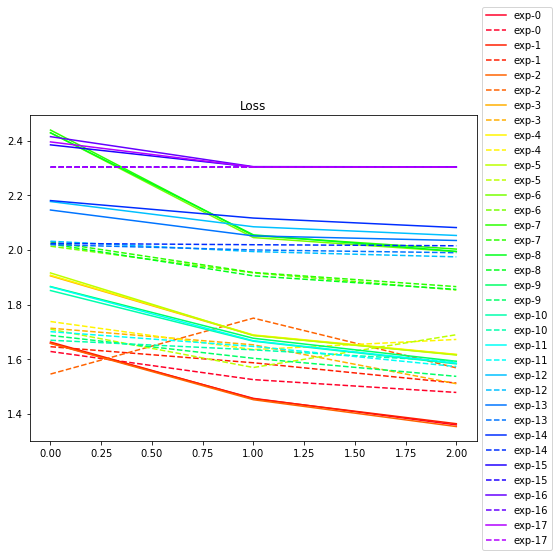

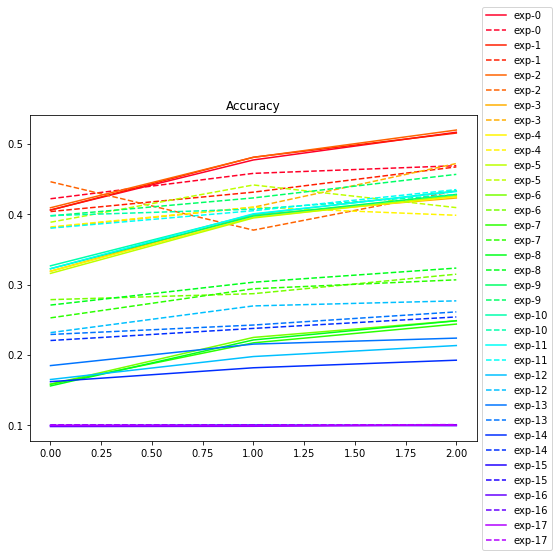

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
import matplotlib.cm as mplcm
import matplotlib.colors as colors

N_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm = colors.Normalize(vmin=0, vmax=N_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(N_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])), results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])), results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title('Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])), results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])), results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title('Accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()